<a href="https://colab.research.google.com/github/abdullahamruf/Mosquito/blob/main/ensemble_2(Inception%2Bvgg%2Bresnet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model('/content/drive/MyDrive/model-05-0.8400.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

Mounted at /content/drive


In [2]:
model_2 = load_model('/content/drive/MyDrive/model2-05-0.5667.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

In [3]:
model_3 = load_model('/content/drive/MyDrive/resnetmosquito-04-0.8000.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

In [4]:
models = [model_1, model_2 ,model_3]
model_input = Input(shape=(299, 299, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [5]:
import tensorflow as tf

In [6]:
base_learning_rate = 0.001
ensemble_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [7]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

In [8]:
IMG_SIZE = (299, 299) # resolution
directory = "/content/drive/MyDrive/zw4p9kj6nt-2"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 1500 files belonging to 6 classes.
Using 1350 files for training.
Found 1500 files belonging to 6 classes.
Using 150 files for validation.


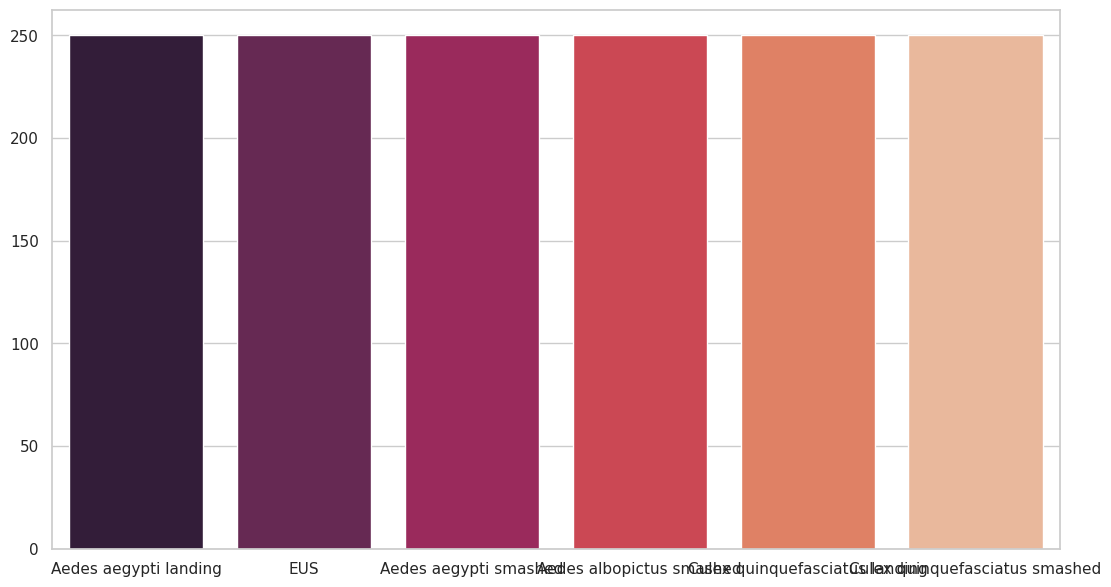

In [9]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=[ "Aedes aegypti landing", "EUS", "Aedes aegypti smashed","Aedes albopictus smashed","Culex quinquefasciatus landing","Culex quinquefasciatus smashed"], y=Data_imbalance, palette="rocket")
plt.show()

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

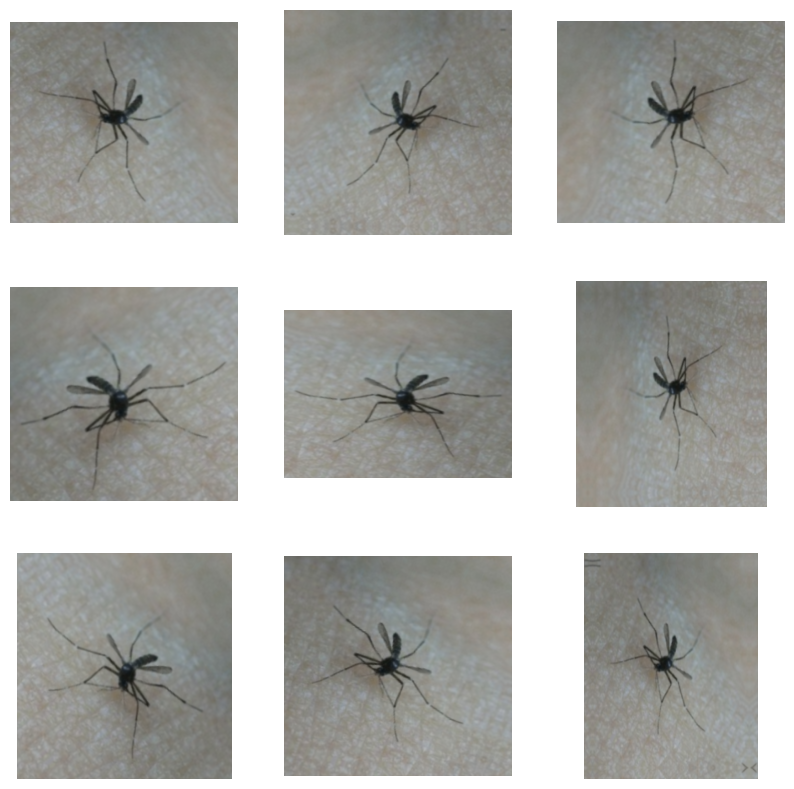

In [11]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [12]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 6.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 6.0)
weight_for_2 = (1 / Data_imbalance[2]) * (total / 6.0)
weight_for_3 = (1 / Data_imbalance[3]) * (total / 6.0)
weight_for_4 = (1 / Data_imbalance[3]) * (total / 6.0)
weight_for_5 = (1 / Data_imbalance[3]) * (total / 6.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3,4: weight_for_4,5: weight_for_5}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))
print('Weight for class 5: {:.2f}'.format(weight_for_5))


Weight for class 0: 1.00
Weight for class 1: 1.00
Weight for class 2: 1.00
Weight for class 3: 1.00
Weight for class 4: 1.00
Weight for class 5: 1.00


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
model_filepath="/content/drive/MyDrive/Colab Notebooks/emsemble-2-best-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath ,
    monitor ='val_accuracy',
    mode = 'max' ,
    save_best_only =True ,
     verbose = 1

)

In [15]:
history = ensemble_model.fit(train_dataset , verbose=2 , epochs=100 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True )

Epoch 1/100
11/11 - 105s - loss: 0.6688 - accuracy: 0.8074 - val_loss: 0.6229 - val_accuracy: 0.8600 - 105s/epoch - 10s/step
Epoch 2/100
11/11 - 24s - loss: 0.5196 - accuracy: 0.8867 - val_loss: 0.5791 - val_accuracy: 0.8400 - 24s/epoch - 2s/step
Epoch 3/100
11/11 - 24s - loss: 0.4617 - accuracy: 0.9081 - val_loss: 0.4995 - val_accuracy: 0.9133 - 24s/epoch - 2s/step
Epoch 4/100
11/11 - 24s - loss: 0.4054 - accuracy: 0.9326 - val_loss: 0.4558 - val_accuracy: 0.9000 - 24s/epoch - 2s/step
Epoch 5/100
11/11 - 25s - loss: 0.3672 - accuracy: 0.9548 - val_loss: 0.4471 - val_accuracy: 0.9000 - 25s/epoch - 2s/step
Epoch 6/100
11/11 - 25s - loss: 0.3384 - accuracy: 0.9585 - val_loss: 0.4339 - val_accuracy: 0.8867 - 25s/epoch - 2s/step
Epoch 7/100
11/11 - 25s - loss: 0.3132 - accuracy: 0.9585 - val_loss: 0.4292 - val_accuracy: 0.8933 - 25s/epoch - 2s/step
Epoch 8/100
11/11 - 25s - loss: 0.3010 - accuracy: 0.9681 - val_loss: 0.3846 - val_accuracy: 0.9067 - 25s/epoch - 2s/step
Epoch 9/100
11/11 - 2

In [16]:
from tensorflow.keras.models import load_model

In [17]:
ensemble_model.evaluate(validation_dataset , verbose = 1)

2/2 [==============================] - 3s 417ms/step - loss: 0.1982 - accuracy: 0.9600


[0.1981823742389679, 0.9599999785423279]

In [18]:
class_names = train_dataset.class_names
class_names

['Aedes  albopictus landing',
 'Aedes aegypti landing',
 'Aedes aegypti smashed',
 'Aedes albopictus smashed',
 'Culex quinquefasciatus landing',
 'Culex quinquefasciatus smashed']

1/1 [==============================] - 0s 33ms/step


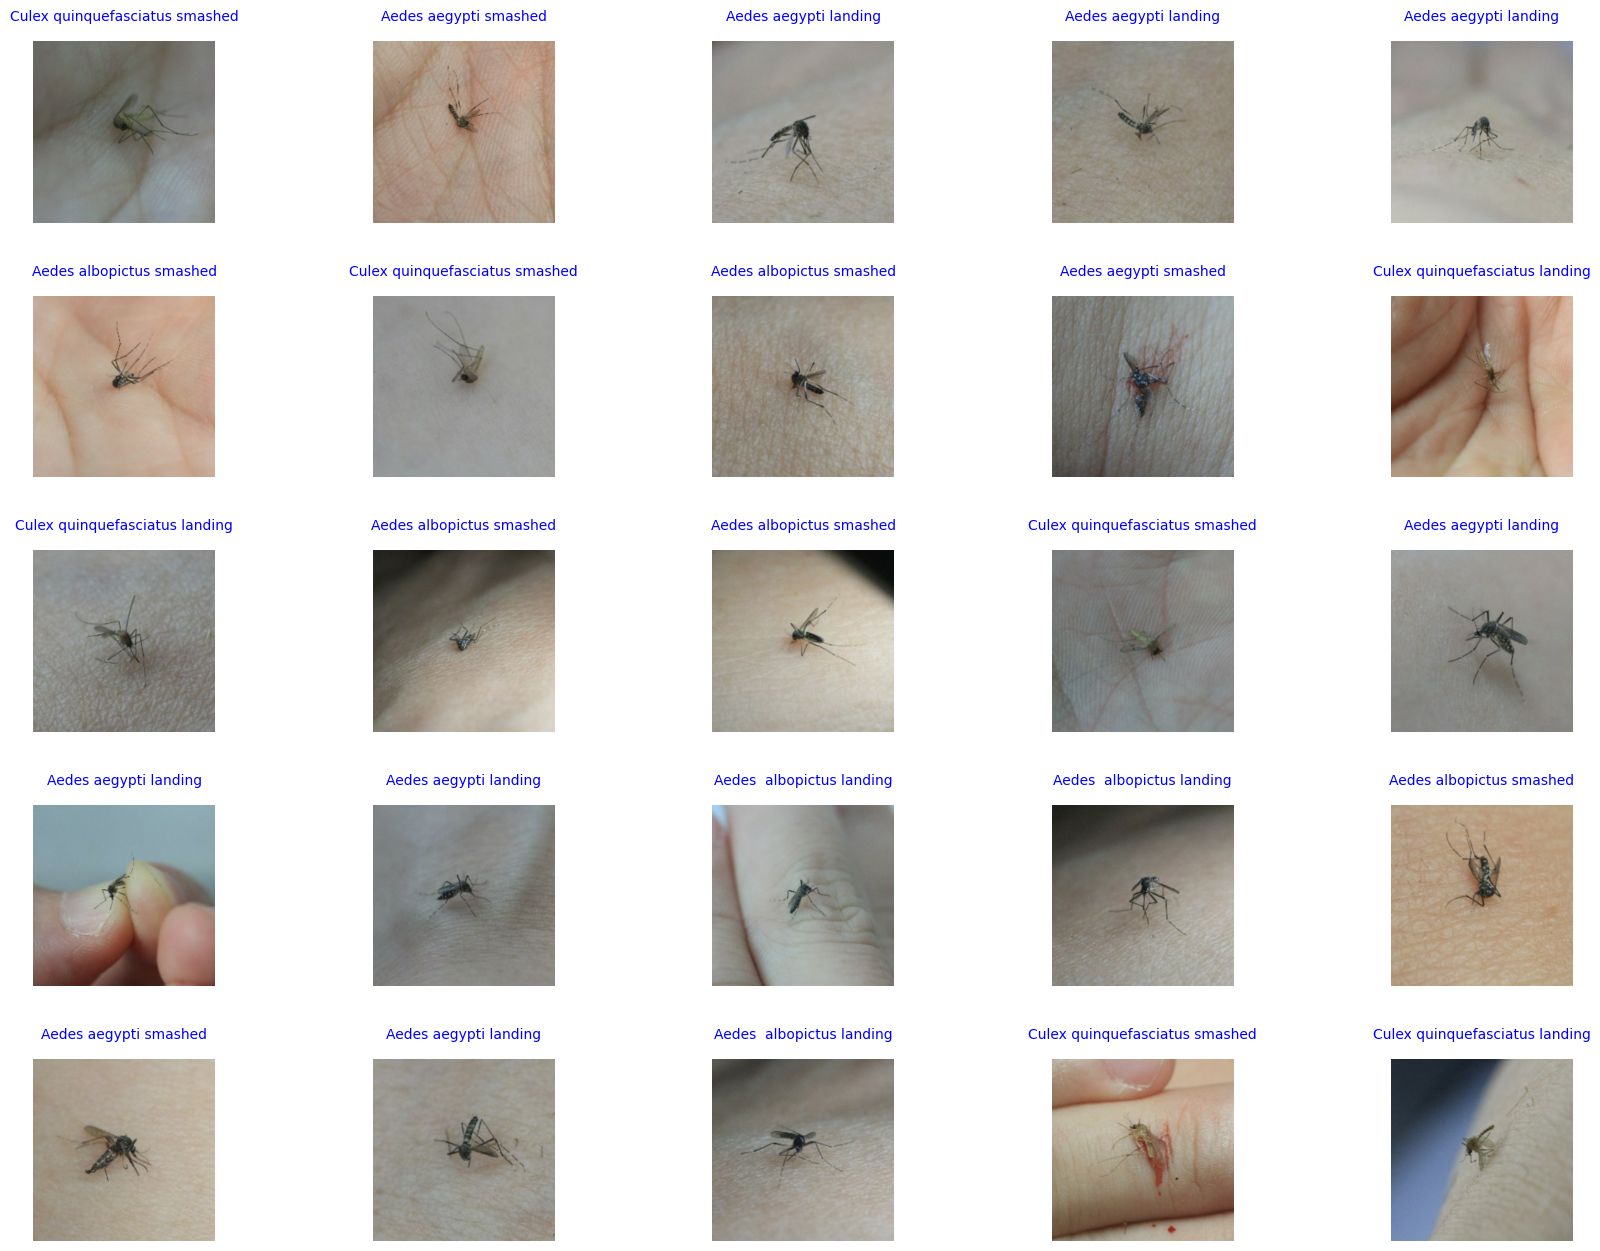

In [19]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = ensemble_model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

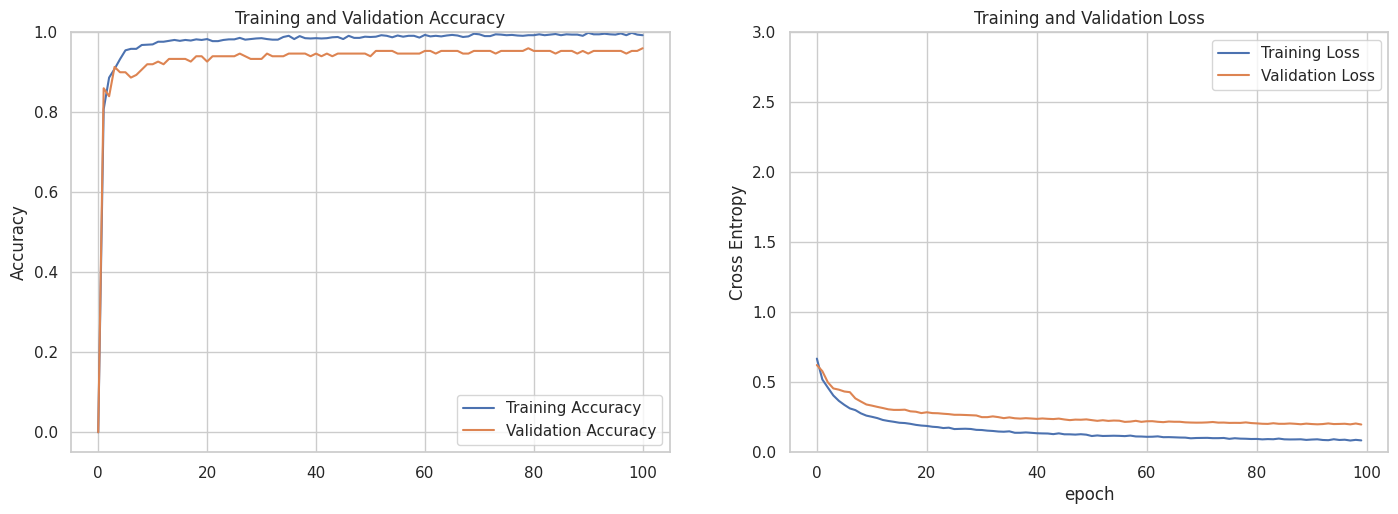

In [20]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 2s 2s/step


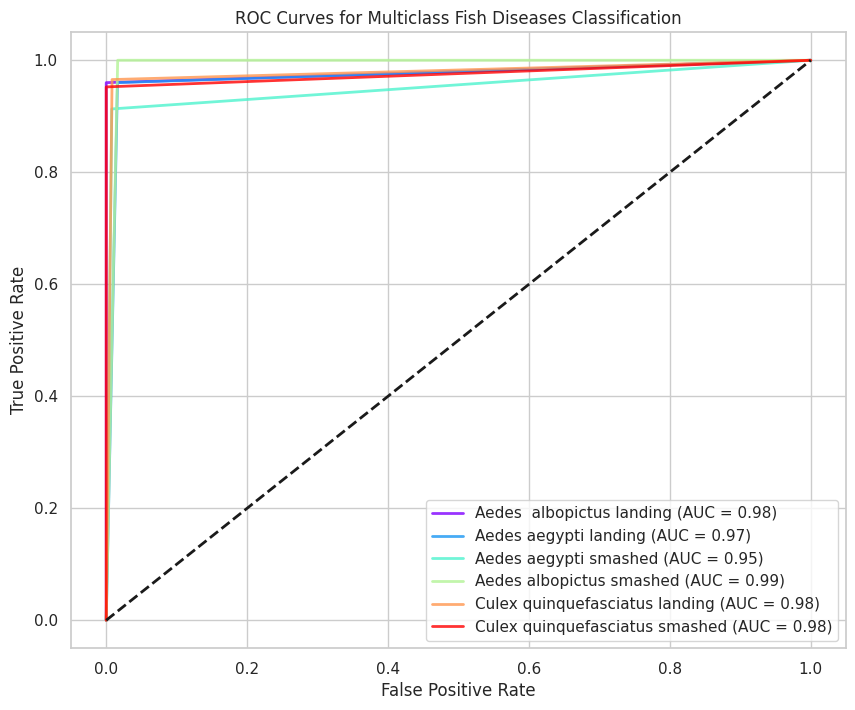

ROC AUC for Aedes  albopictus landing: 0.9800
ROC AUC for Aedes aegypti landing: 0.9720
ROC AUC for Aedes aegypti smashed: 0.9526
ROC AUC for Aedes albopictus smashed: 0.9919
ROC AUC for Culex quinquefasciatus landing: 0.9786
ROC AUC for Culex quinquefasciatus smashed: 0.9762
                                precision    recall  f1-score   support

     Aedes  albopictus landing       1.00      0.96      0.98        25
         Aedes aegypti landing       0.92      0.96      0.94        25
         Aedes aegypti smashed       0.95      0.91      0.93        23
      Aedes albopictus smashed       0.93      1.00      0.96        27
Culex quinquefasciatus landing       0.97      0.97      0.97        29
Culex quinquefasciatus smashed       1.00      0.95      0.98        21

                      accuracy                           0.96       150
                     macro avg       0.96      0.96      0.96       150
                  weighted avg       0.96      0.96      0.96       150



In [21]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in validation_dataset:
    predictions = ensemble_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))

# Compute class-specific ROC AUC values
roc_auc_per_class = []
for i in range(len(class_names)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc_per_class.append(roc_auc)

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Plot class-specific ROC curves with different colors and line styles
plt.figure(figsize=(10, 8))

colors = plt.cm.rainbow(np.linspace(0, 1, len(class_names)))

for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr, tpr,
        label=f'{class_names[i]} (AUC = {roc_auc:.2f})',
        color=color,
        linestyle='-',  # You can customize line styles here
        linewidth=2,  # You can customize line width here
        alpha=0.8  # You can customize transparency here
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Fish Diseases Classification')
plt.legend(loc='lower right')
plt.grid(True)  # Add a grid for better readability
plt.show()

# Print class-specific ROC AUC values
for i in range(len(class_names)):
    print(f'ROC AUC for {class_names[i]}: {roc_auc_per_class[i]:.4f}')

# Print the classification report
print(report)


In [22]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.9519


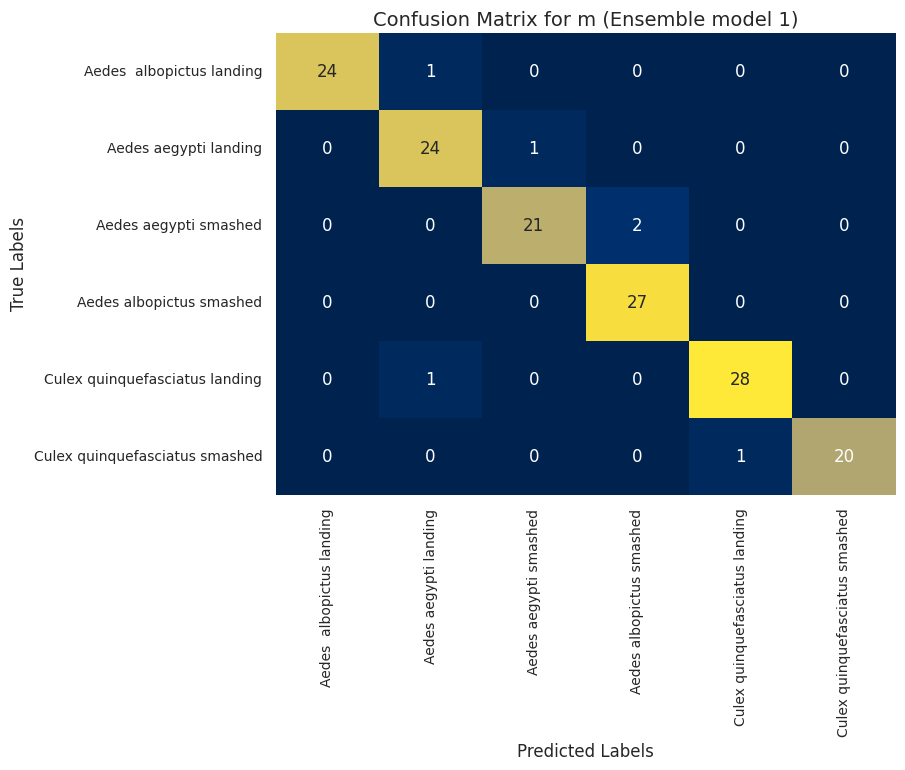

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Set a custom color palette (cividis is a good choice for accessibility)
custom_palette = sns.color_palette("cividis", as_cmap=True)

# Plot the confusion matrix as a heatmap with custom styling
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette, xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix for m (Ensemble model 1)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [24]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming true_labels and predicted_labels are your multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')


Average Matthews Correlation Coefficient for Multiclass: 0.9523


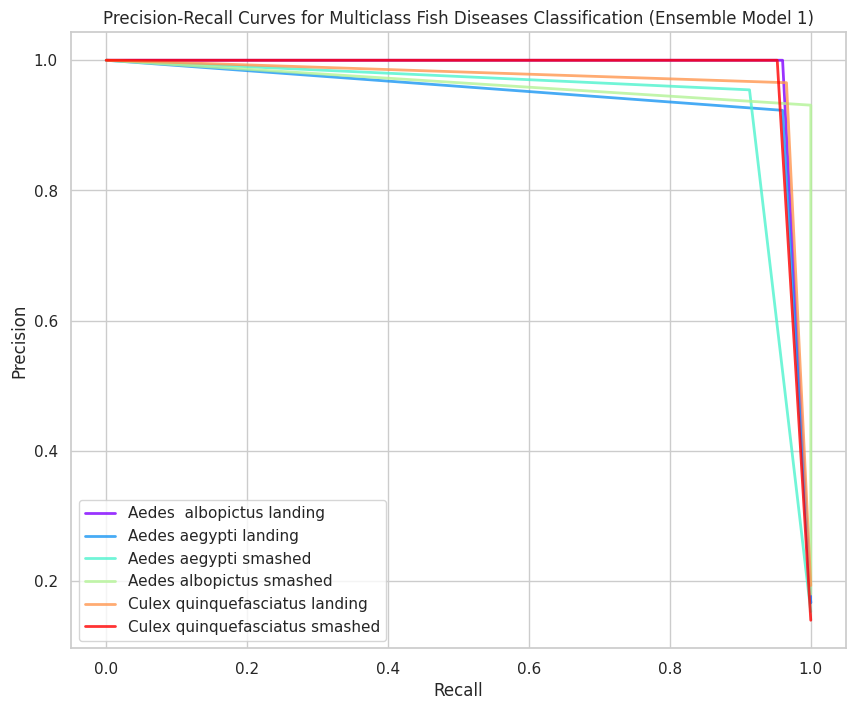

In [25]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(10, 8))

for i, color in zip(range(len(class_names)), colors):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    plt.plot(
        recall, precision,
        label=f'{class_names[i]}',
        color=color,
        linestyle='-',
        linewidth=2,
        alpha=0.8
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multiclass Fish Diseases Classification (Ensemble Model 1)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


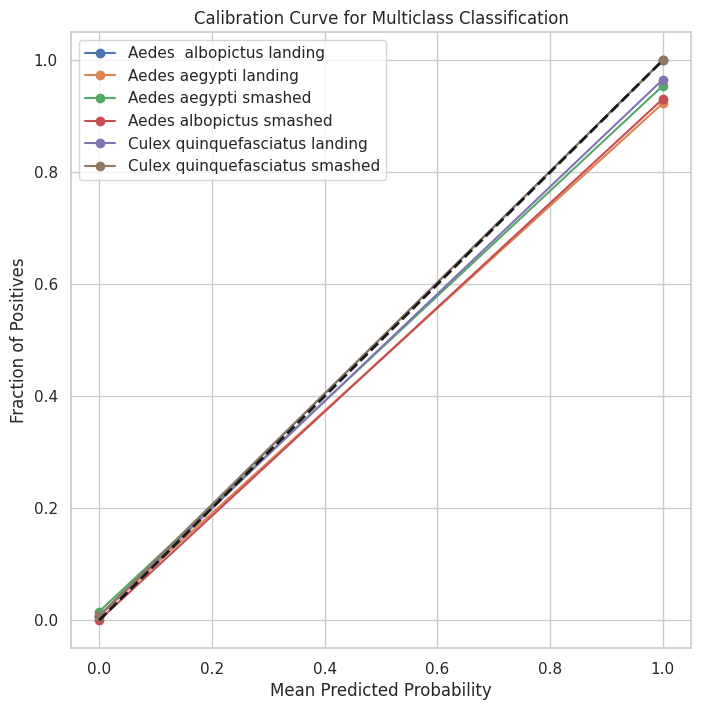

In [26]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 8))

for i in range(len(class_names)):
    prob_true, prob_pred = calibration_curve(true_labels_bin[:, i], predicted_labels_bin[:, i], n_bins=10, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', label=f'{class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve for Multiclass Classification')
plt.legend(loc='upper left')
plt.show()

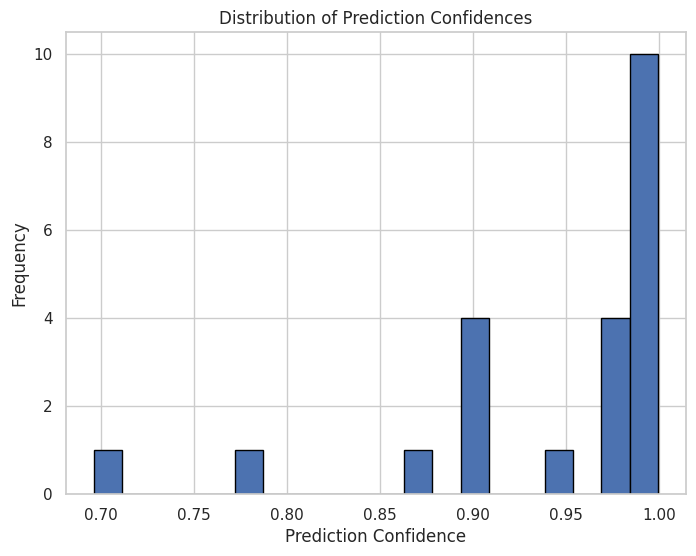

In [29]:
# Assuming predictions is a matrix of predicted probabilities for each class
prediction_confidences = np.max(predictions, axis=1)

# Plot histogram of prediction confidences
plt.figure(figsize=(8, 6))
plt.hist(prediction_confidences, bins=20, edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidences')
plt.show()
